In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon April 29 13:25:11 2020

@author: rfuchs
"""

import os 

%matplotlib inline
import pandas as pd
from copy import deepcopy
from gower import gower_matrix
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import LabelEncoder 

from MIAMI import MIAMI
from init_params import dim_reduce_init
from data_preprocessing import compute_nj

from shapely.geometry import Polygon as polygon

import autograd.numpy as np

from sklearn.preprocessing import MinMaxScaler

from scipy.spatial.distance import pdist, squareform


In [2]:

res_folder = 'MIAMI/Results/structure/'


        




    
dtypes_dict = {'continuous': float, 'categorical': str, 'ordinal': int,\
              'bernoulli': int, 'binomial': int}
#===========================================#
# Importing data
#===========================================#

inf_nb = 1E12

sub_design = "bivariate"

# acceptance_rate =
le_dict = {}

import json
with open(res_folder + "optimal_run.json") as f:
    synthetic = json.load(f)
with open(res_folder + "real_structures.json") as f:
    real = json.load(f)
with open(res_folder + "random_dataset_1000_designs.json") as f:
    rand = json.load(f)
    
    
# from https://stackoverflow.com/questions/38592324/one-hot-encoding-using-numpy
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

brace_dict = {    
    "NONE": 0,
    "H": 1,
    "Z": 2,
    "IZ": 3,
    "ZH": 4,
    "IZH": 5,
    "K": 6,
    "X": 7,
    "XH": 8,
}

brace_dict_inv = dict(zip(brace_dict.values(), brace_dict.keys()))

N_BRACES = len(brace_dict)
def encode(d, max_layers, one_hot=True, native=False):
    basics = [d["legs"], d["total_height"], d["radius_bottom"], d["radius_top"], d["n_layers"]]
    
    # fill design's braces according to max_layers with dummies ("NONE")
    braces = d["connection_types"]
    if native:
        braces = np.array([b for b in braces] + ["NONE"] * (max_layers - 1 - len(braces)))
    else:
        braces = np.array([brace_dict[b] for b in braces] + [brace_dict["NONE"]] * (max_layers - 1 - len(braces)))
        if one_hot:
            braces = get_one_hot(braces, N_BRACES)
    
    # fill design's layer_heights according to max_layers with dummies
    layer_heights = d["layer_heights"]
    layer_heights = np.array(layer_heights + [d["total_height"]] * (max_layers - 2 - len(layer_heights))) / d["total_height"]
    
    # return a flat encoding
    return np.array([*basics, *braces.flatten(), *layer_heights])

def get_cols(d, max_layers, one_hot=True, native=False):
    
    # fill design's braces according to max_layers with dummies ("NONE")
    braces = d["connection_types"]
    if native:
        braces = np.array([b for b in braces] + ["NONE"] * (max_layers - 1 - len(braces)))
    else:
        braces = np.array([brace_dict[b] for b in braces] + [brace_dict["NONE"]] * (max_layers - 1 - len(braces)))
        if one_hot:
            braces = get_one_hot(braces, N_BRACES)
    
    # fill design's layer_heights according to max_layers with dummies
    layer_heights = d["layer_heights"]
    layer_heights = np.array(layer_heights + [d["total_height"]] * (max_layers - 2 - len(layer_heights))) / d["total_height"]
    transformed_columns = ["legs", "total_height", "radius_bottom", "radius_top", "n_layers"] + ["brace" + str(i) for i in range(len(braces.flatten()))] + ["layer_height" + str(i) for i in range(len(layer_heights))]
    
    # return a flat encoding
    return transformed_columns, ["brace" + str(i) for i in range(len(braces.flatten()))]

max_layers = max([d["n_layers"] for d in real] + [d["n_layers"] for d in synthetic] + [d["n_layers"] for d in rand])

encodings_real = [encode(d, max_layers, one_hot=False, native=True) for d in real]
transformed_columns, brace_cols = get_cols(real[0], max_layers, one_hot=False)

encodings_rand = [encode(d, max_layers, one_hot=False, native=True) for d in rand]
transformed_columns, brace_cols = get_cols(rand[0], max_layers, one_hot=False)

encodings_synthetic = [encode(d, max_layers, one_hot=False, native=True) for d in synthetic]
transformed_columns, brace_cols = get_cols(synthetic[0], max_layers, one_hot=False)

real = pd.DataFrame(encodings_real, columns=transformed_columns)
synthetic = pd.DataFrame(encodings_synthetic, columns=transformed_columns)
rand = pd.DataFrame(encodings_rand, columns=transformed_columns)

# Assuming the "real" and "synthetic" dataframes have different number of rows
label_real = ["real"] * len(real)
label_synthetic = ["synthetic (GA)"] * len(synthetic)
label_rand = ["random"] * len(rand)

real['label'] = label_real  # add the label column to the "real" dataframe
synthetic['label'] = label_synthetic  # add the label column to the "synthetic" dataframe
rand['label'] = label_rand  # add the label column to the "synthetic" dataframe

# Concatenate the two dataframes together and reindex
# train_original = pd.concat([real, synthetic, rand], axis=0, ignore_index=True)
train_original = pd.concat([real, synthetic], axis=0, ignore_index=True)

nominal_features = brace_cols
ordinal_features = ["n_layers", "legs"]


continuous_features = list(set(transformed_columns) - set(nominal_features) - set(ordinal_features))

train_original[ordinal_features] = train_original[ordinal_features].astype("int")
train_original[continuous_features] = train_original[continuous_features].astype("float")


train = train_original.drop("label", axis=1)





train = train.infer_objects()



numobs = len(train)
print("Running with", numobs, "observations!!!!")

Running with 150 observations!!!!


In [3]:
#*****************************************************************
# Formating the data
#*****************************************************************
# 
unique_counts = train.nunique()


var_distrib = []     
# Encode categorical datas
for colname, dtype, unique in zip(train.columns, train.dtypes, train.nunique()):
    if unique < 2:
        print("Dropped", colname, "because of 0 var")
        train.drop(colname, axis=1, inplace=True)
        continue

    if dtype==int or dtype == "object" and unique==2:
        #bool
        var_distrib.append('bernoulli')
        le = LabelEncoder()
        # Convert them into numerical values               
        train[colname] = le.fit_transform(train[colname]) 
        le_dict[colname] = deepcopy(le)
    elif dtype==int and unique > 2:
        # ordinal
        var_distrib.append('ordinal')
        le = LabelEncoder()
        # Convert them into numerical values               
        train[colname] = le.fit_transform(train[colname]) 
        le_dict[colname] = deepcopy(le)
    elif dtype == "object":
        var_distrib.append('categorical')
        le = LabelEncoder()
        # Convert them into numerical values               
        train[colname] = le.fit_transform(train[colname]) 
        le_dict[colname] = deepcopy(le)
    elif dtype == float:
        var_distrib.append('continuous')
    
var_distrib = np.array(var_distrib)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()
float_cols = train.select_dtypes(include=['float']).columns
# Normalize the continuous features
train.loc[:, float_cols] = scaler.fit_transform(train.loc[:, float_cols])

nj, nj_bin, nj_ord, nj_categ = compute_nj(train, var_distrib)

nb_cont = np.sum(var_distrib == 'continuous')     

p = train.shape[1]
        
# Feature category (cf)
dtype = {train.columns[j]: dtypes_dict[var_distrib[j]] for j in range(p)}

train = train.astype(dtype, copy=True)
numobs = len(train)

authorized_ranges = np.expand_dims(np.stack([[-np.inf,np.inf] for var in var_distrib]).T, 1)
authorized_ranges = None
print(*zip(train.columns,var_distrib, train.dtypes))


('legs', 'bernoulli', dtype('int64')) ('total_height', 'continuous', dtype('float64')) ('radius_bottom', 'continuous', dtype('float64')) ('radius_top', 'continuous', dtype('float64')) ('n_layers', 'bernoulli', dtype('int64')) ('brace0', 'categorical', dtype('O')) ('brace1', 'categorical', dtype('O')) ('brace2', 'categorical', dtype('O')) ('brace3', 'categorical', dtype('O')) ('brace4', 'categorical', dtype('O')) ('brace5', 'categorical', dtype('O')) ('layer_height0', 'continuous', dtype('float64')) ('layer_height1', 'continuous', dtype('float64')) ('layer_height2', 'continuous', dtype('float64')) ('layer_height3', 'continuous', dtype('float64')) ('layer_height4', 'continuous', dtype('float64'))


In [4]:
train

,legs,total_height,radius_bottom,radius_top,n_layers,brace0,brace1,brace2,brace3,brace4,brace5,layer_height0,layer_height1,layer_height2,layer_height3,layer_height4
0,1,0.058065,0.411765,0.766452,0,3,2,1,2,2,0,1.000000,1.000000,1.000000,1.00000,1.000000
1,0,0.767742,0.640257,0.538404,1,3,3,1,2,2,0,0.540803,1.000000,1.000000,1.00000,1.000000
2,1,0.198710,0.606040,0.230513,1,3,3,1,2,2,0,0.540942,1.000000,1.000000,1.00000,1.000000
3,0,0.419355,0.370060,0.354728,1,3,3,1,2,2,0,0.476699,1.000000,1.000000,1.00000,1.000000
4,0,0.432258,0.518939,0.392605,1,3,3,1,2,2,0,0.544404,1.000000,1.000000,1.00000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,1,0.938551,0.553728,1.000000,5,3,4,1,3,4,0,0.200186,0.087046,0.000000,0.00000,0.971377
146,1,0.428356,0.294965,0.434140,4,1,3,2,1,2,0,0.392085,0.420130,0.918188,0.91156,1.000000
147,0,0.428356,0.050481,0.432878,1,1,1,1,2,2,0,0.596589,1.000000,1.000000,1.00000,1.000000
148,1,0.938551,0.553728,0.838841,5,4,1,1,4,1,1,0.200186,0.124142,0.000000,0.00000,0.971377


In [5]:
sub_design = "none"


In [6]:
#*****************************************************************
# Sampling rules
#*****************************************************************    
authorized_ranges = np.expand_dims(np.stack([[-np.inf,np.inf] for var in var_distrib]).T, 1)


In [7]:
#===========================================#
# Model Hyper-parameters
#===========================================#

n_clusters = 3
r = np.array([2, 1])
k = [n_clusters]

seed = 1
init_seed = 2
    
# !!! Changed eps
eps = 1E-05
it = 50
maxstep = 100
nb_pobs = 100

#*****************************************************************
# Run MIAMI
#*****************************************************************

print("Initialize dimensionality reduction")    
init, transformed_famd_data  = dim_reduce_init(train, n_clusters, k, r, nj, var_distrib, seed = None,\
                                use_famd=True)

print("Computing distance matrix")
# # Defining distances over the features
# dm = gower_matrix(train, cat_features = cat_features) 

distances = pdist(transformed_famd_data)

dm = squareform(distances)


Initialize dimensionality reduction
Computing distance matrix


/home/panagiotou/Desktop/M1DGMM/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/panagiotou/Desktop/M1DGMM/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

In [8]:
print("Training")
out = MIAMI(train, n_clusters, r, k, init, var_distrib, nj, authorized_ranges, nb_pobs, it=it,\
                eps=eps, maxstep=maxstep, seed=seed, perform_selec = True, dm = dm, max_patience = 0)
print('MIAMI has kept one observation over', round(1 / out['share_kept_pseudo_obs']),\
        'observations generated')
    
acceptance_rate = out['share_kept_pseudo_obs']
print(acceptance_rate)
pred = pd.DataFrame(out['y_all'], columns = train.columns) 

Training
Iteration 0
Likelyhood [-2715.0533393741816]
silhouette [-1]
Iteration 1
Likelyhood [-2715.0533393741816, -2567.4478081031534]
silhouette [-1, 0.9323306255992031]
Iteration 2
Likelyhood [-2715.0533393741816, -2567.4478081031534, -2535.703889144126]
silhouette [-1, 0.9323306255992031, 0.8355234510060511]
Iteration 3
Likelyhood [-2715.0533393741816, -2567.4478081031534, -2535.703889144126, -2550.7954608058026]
silhouette [-1, 0.9323306255992031, 0.8355234510060511, 0.8355234510060511]
MIAMI has kept one observation over 1 observations generated
0.9900990099009901


In [9]:
#================================================================
# Inverse transform the datasets
#================================================================
pred_trans = pred.copy()
for j, colname in enumerate(train.columns):
    if colname in le_dict.keys():
        pred_trans[colname] = le_dict[colname].inverse_transform(pred[colname].astype(int))
    
pred_trans.loc[:, var_distrib == 'continuous'] = pred_trans.loc[:, var_distrib == 'continuous'].round(0)

print("Saved to", res_folder + 'preds.csv')
# Store the predictions
pred_trans.to_csv(res_folder + 'preds.csv', index = False)
#break

Saved to MIAMI/Results/structure/preds.csv


In [10]:
pred

,legs,total_height,radius_bottom,radius_top,n_layers,brace0,brace1,brace2,brace3,brace4,brace5,layer_height0,layer_height1,layer_height2,layer_height3,layer_height4
0,1.0,0.716674,0.412171,0.279179,3.0,2.0,1.0,2.0,2.0,2.0,0.0,0.164079,0.638018,0.836193,1.122566,0.821897
1,1.0,0.609378,0.810701,0.434806,1.0,3.0,3.0,2.0,2.0,2.0,0.0,0.108568,0.605715,1.304346,1.209391,0.927961
2,1.0,0.853561,1.024412,0.468379,2.0,3.0,2.0,2.0,2.0,2.0,0.0,0.358596,0.923046,0.946973,1.285203,1.149411
3,1.0,0.823439,0.217773,0.360531,3.0,3.0,3.0,2.0,2.0,2.0,0.0,0.515416,1.183802,1.003868,1.155337,1.092367
4,0.0,0.516863,0.291148,0.549049,1.0,3.0,1.0,2.0,2.0,2.0,0.0,0.340147,1.033881,1.250045,0.769634,0.868587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,0.459457,0.649416,0.431213,1.0,2.0,3.0,2.0,2.0,2.0,0.0,0.385576,0.205335,1.120456,0.733706,1.013341
96,1.0,0.782901,0.312315,0.565363,1.0,3.0,3.0,2.0,2.0,2.0,0.0,0.443668,0.807423,0.912011,1.307033,1.134784
97,1.0,0.916338,0.829871,0.352322,1.0,3.0,4.0,2.0,2.0,2.0,0.0,0.486969,0.561920,0.566047,0.893036,1.240009
98,1.0,0.612773,0.461857,0.736478,5.0,4.0,1.0,1.0,4.0,1.0,1.0,0.440865,0.423047,-0.463559,0.038689,1.075318


In [11]:
print(out.keys())

dict_keys(['classes', 'best_z', 'Ez.y', 'best_k', 'best_r', 'best_w_s', 'lambda_bin', 'lambda_ord', 'lambda_categ', 'lambda_cont', 'eta', 'mu', 'sigma', 'psl_y', 'ps_y', 'psi', 'H', 'w_s', 'likelihood', 'silhouette', 'zz', 'y_all', 'share_kept_pseudo_obs'])


In [12]:
print(acceptance_rate)

0.9900990099009901


In [13]:
# zz = out["zz"]

# # z2 = np.vstack([zzz for zzz in zz if len(zzz) >0])
# # plt.scatter(z2[:,0], z2[:,1])
# # x1,y1 = polygon.exterior.coords.xy
# # plt.plot(x1,y1)


# # Compare woman, 60+ y.o and people presenting both modalities
# zz = np.concatenate(out['zz'])


# fig, ax = plt.subplots(figsize = (9, 9))
# ax.scatter(out['Ez.y'][:,0], out['Ez.y'][:,1], c='blue', label = '(Train set)')
# ax.scatter(zz[:,0], zz[:,1], c='darkgreen', label = '(MIAMI) synthetic')
# #plt.title('Latent representation of women and 60+ y.o. individuals from the train set and generated by MIAMI')
# plt.legend()
# plt.show()

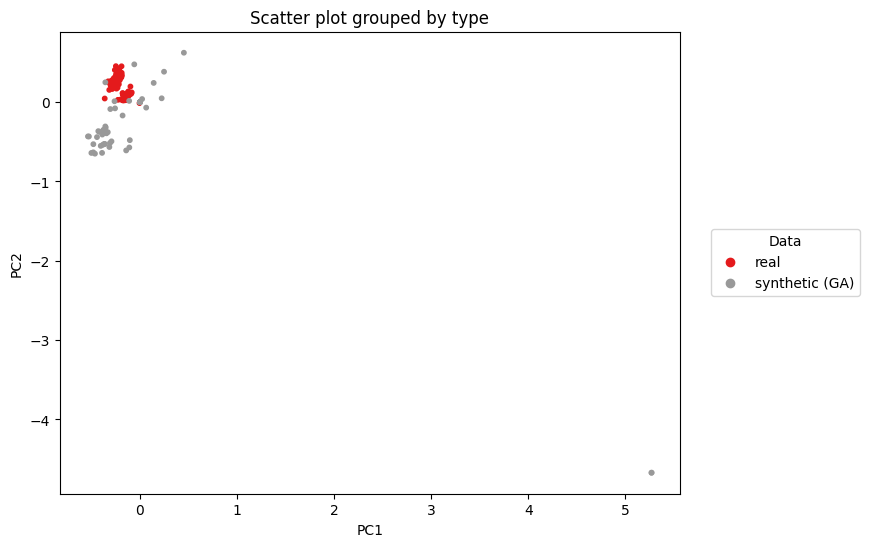

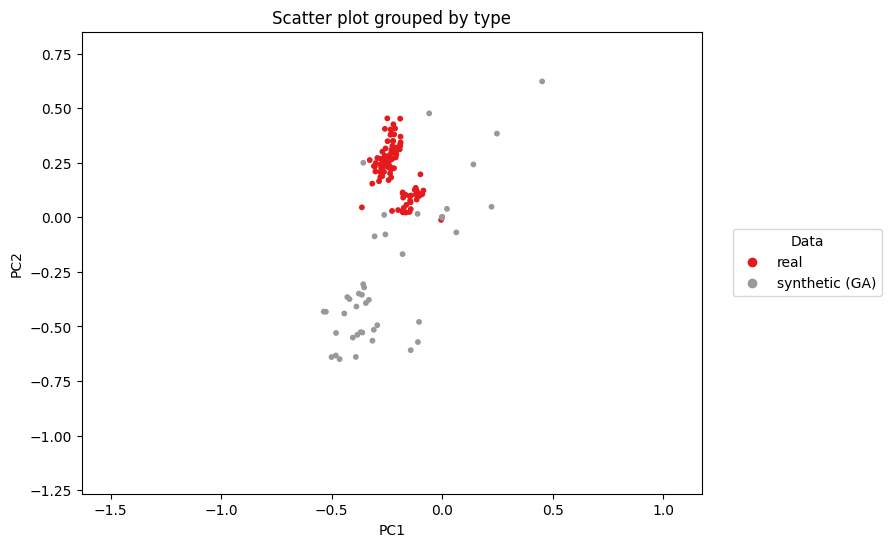

In [39]:
zz = out["zz"]
npzz = np.array(zz)
npzz = np.reshape(npzz, (npzz.shape[0], npzz.shape[-1]))

mean = np.mean(npzz, axis=0)
var = np.std(npzz, axis=0)
var_s = 2


x_lim = [mean[0] - var_s*var[0], mean[0] + var_s*var[0]]
y_lim = [mean[1] - var_s*var[1], mean[1] + var_s*var[1]]

def plot_discr(out, train_original, x_lim=[], y_lim=[]):
    df_scatter = pd.DataFrame()
    df_scatter["x"] = out['Ez.y'][:,0]
    df_scatter["y"] = out['Ez.y'][:,1]

    zz = np.concatenate(out['zz'])
    df_scatter["c"] = train_original["label"]
    df_scatter["label"] = train_original["label"]
    # Convert the labels to numeric values
    labels, levels = pd.factorize(df_scatter['label'])

    # Create a scatter plot
    fig, ax = plt.subplots(figsize=(8, 6))
    scatter = ax.scatter(x=df_scatter['x'], y=df_scatter['y'], c=labels, cmap='Set1', s=10)

    # Add a title and axis labels
    ax.set_title('Scatter plot grouped by type')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

    # Create a legend
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles, levels, loc='center left', bbox_to_anchor=(1.05, 0.5), title="Data", borderaxespad=0.)
    if len(x_lim)>0:
        ax.set_xlim(x_lim[0], x_lim[1])
        ax.set_ylim(y_lim[0], y_lim[1])
    plt.show()

plot_discr(out, train_original)
plot_discr(out, train_original, x_lim=x_lim, y_lim=y_lim)

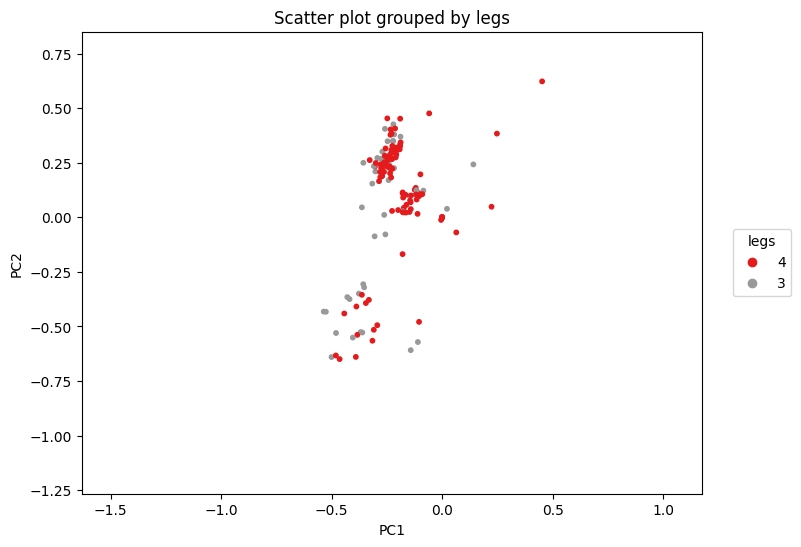

Identified outliers: 5


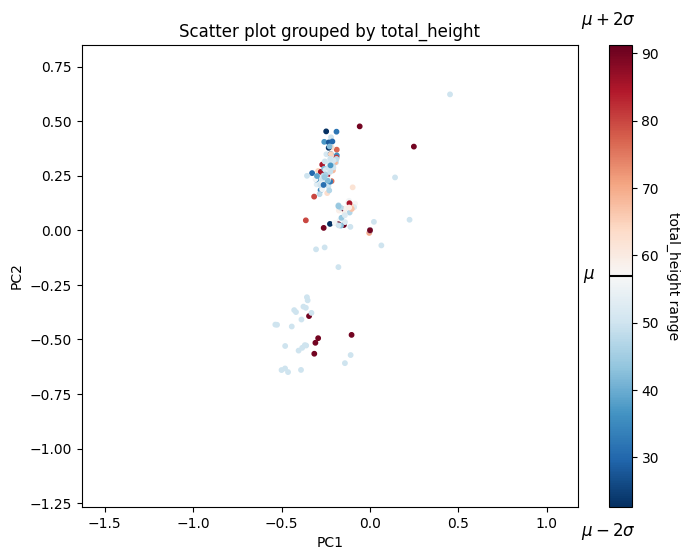

Identified outliers: 3


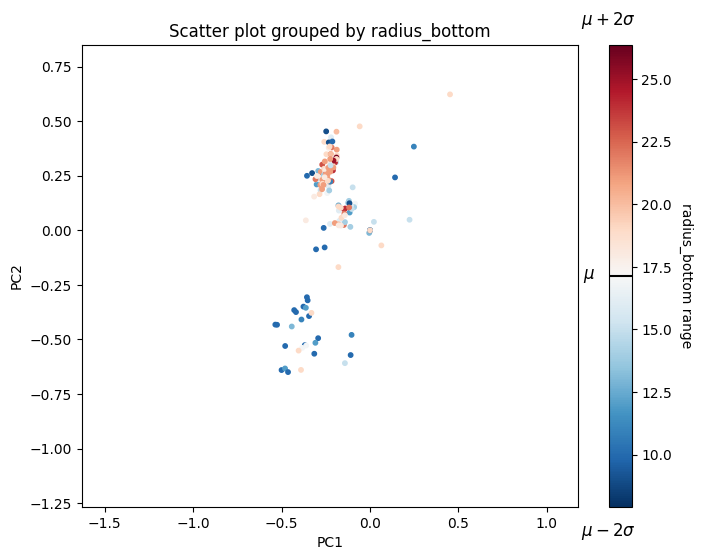

Identified outliers: 13


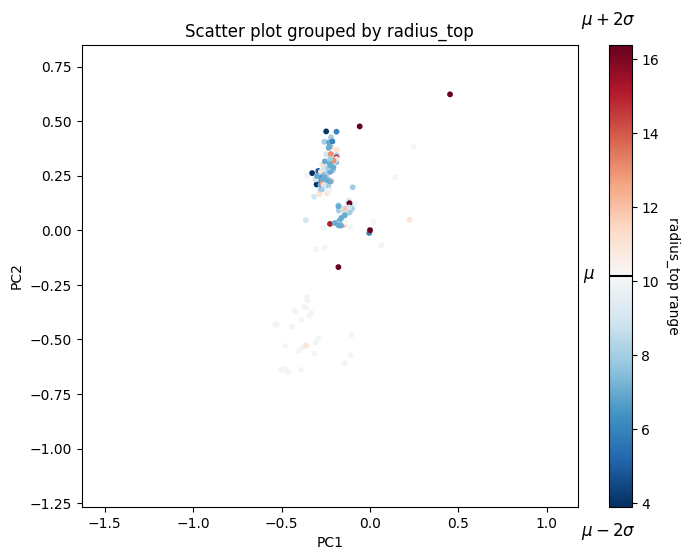

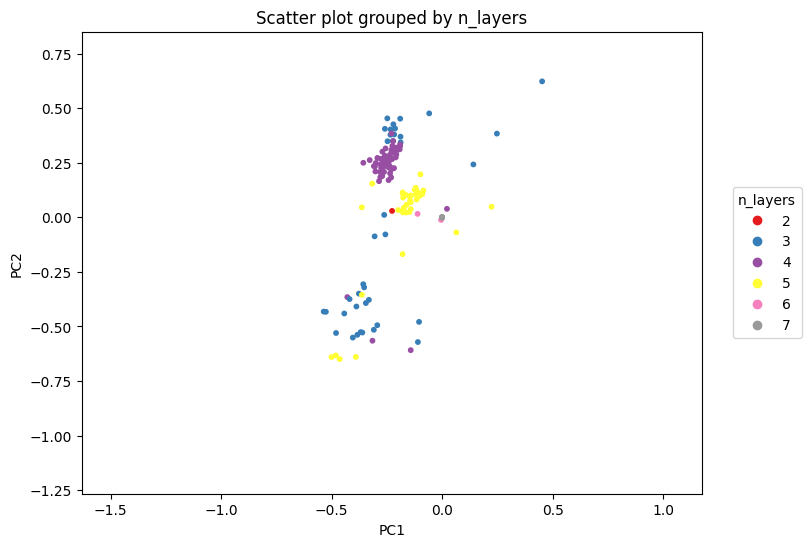

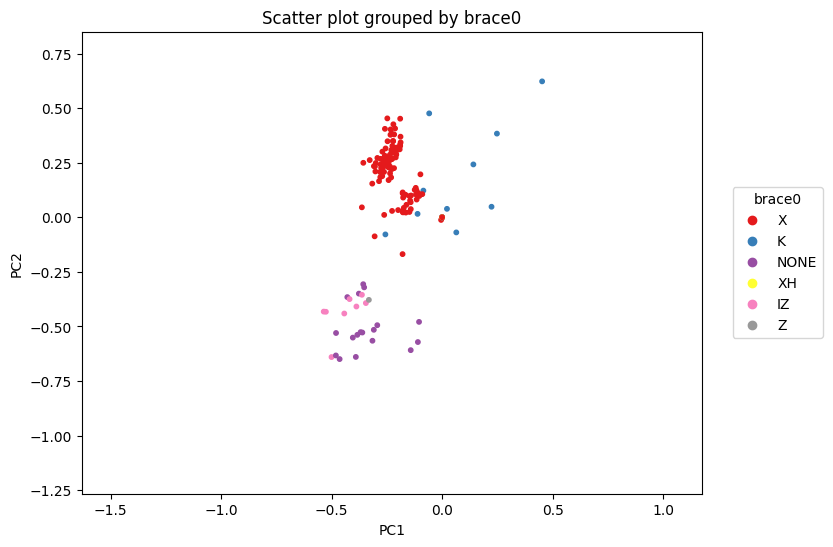

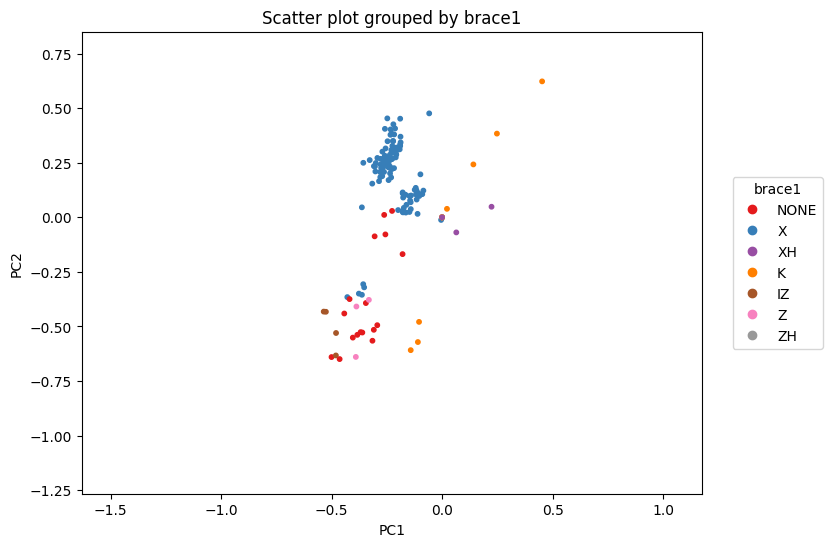

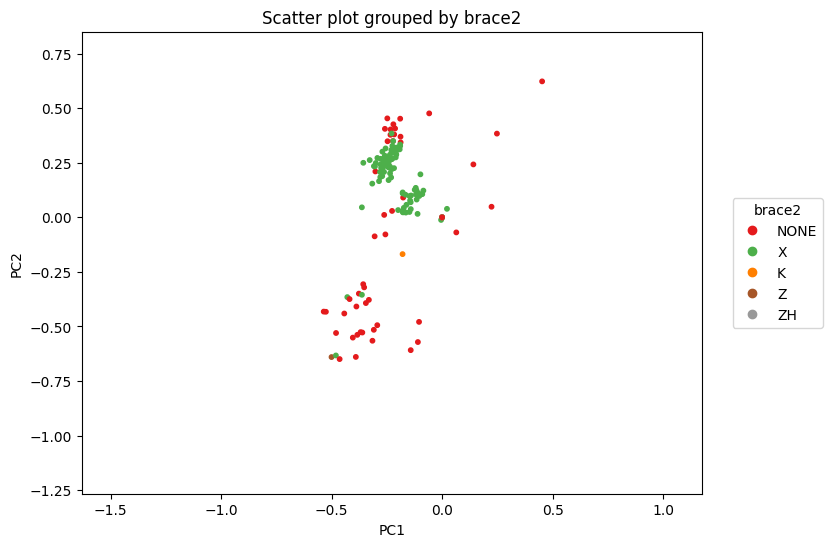

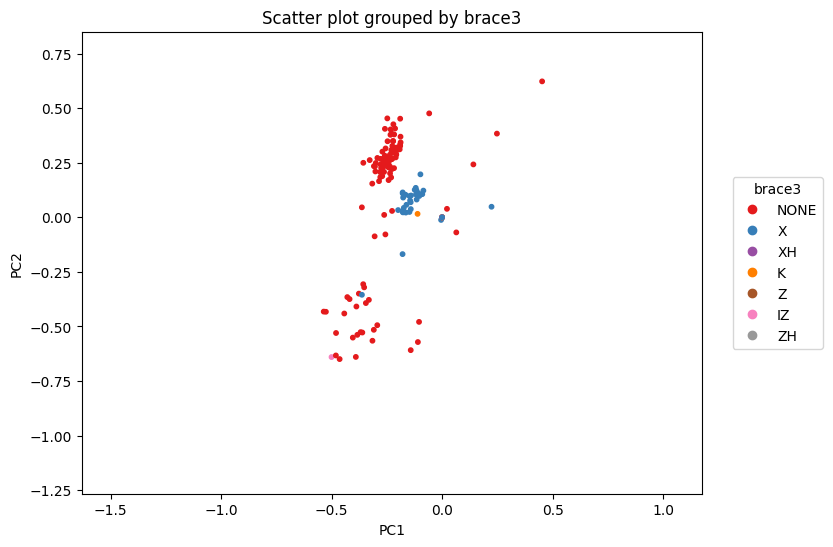

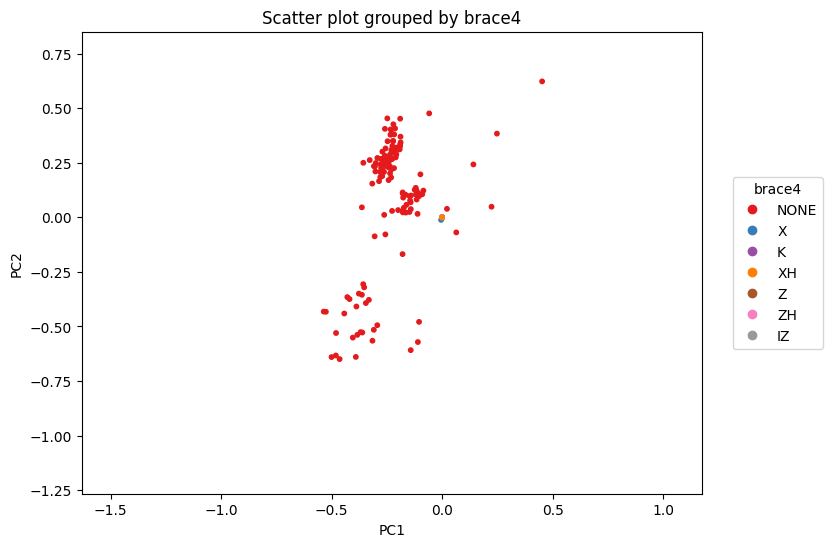

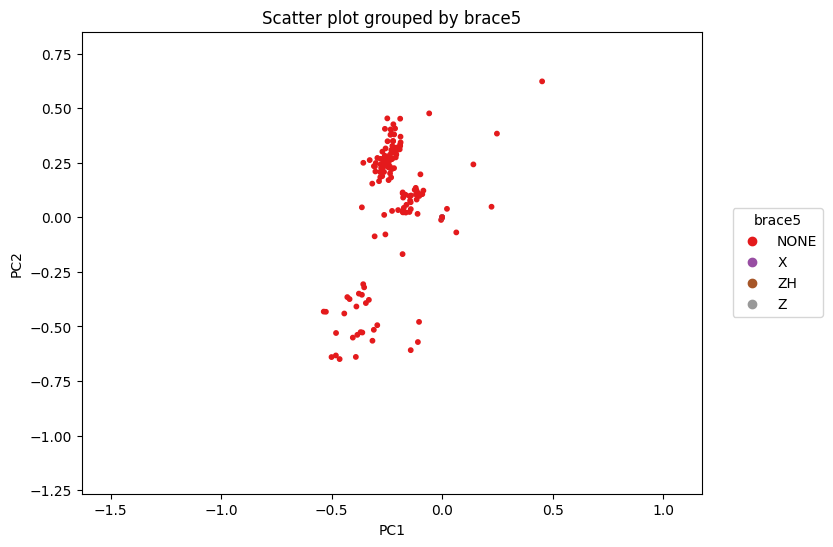

Identified outliers: 12


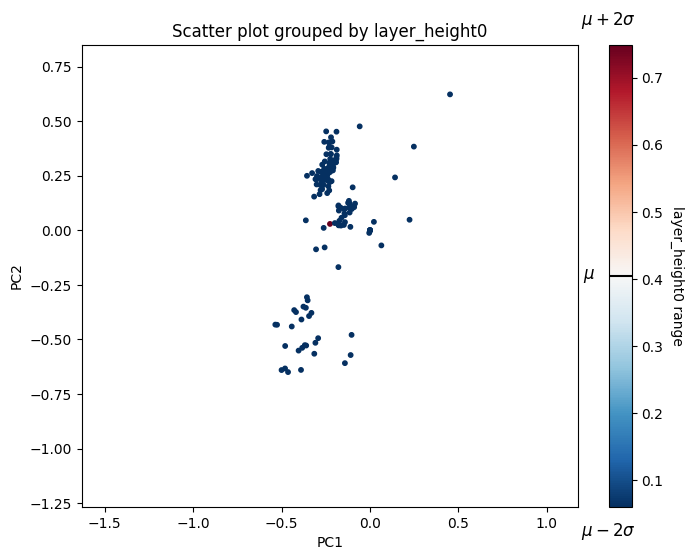

Identified outliers: 6


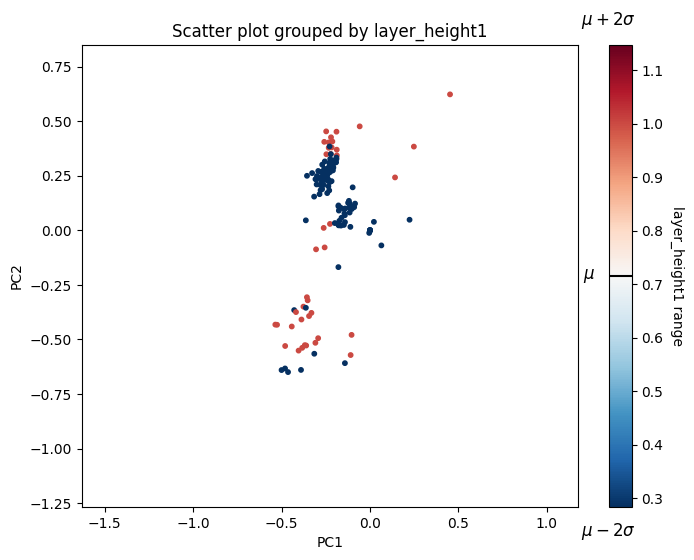

Identified outliers: 9


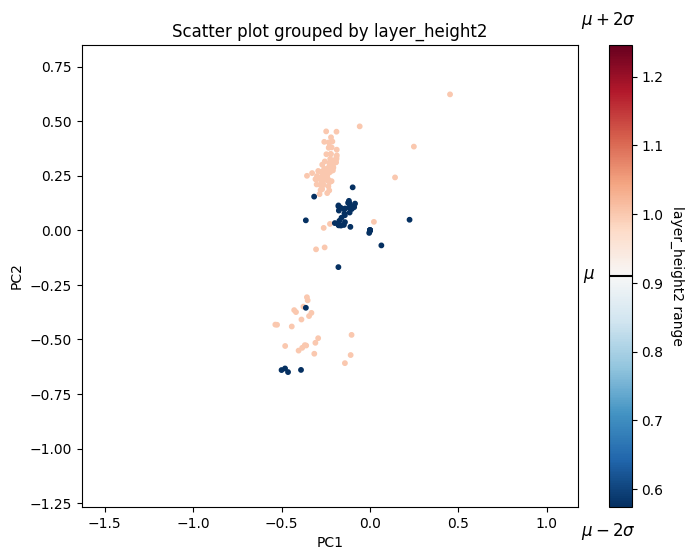

Identified outliers: 9


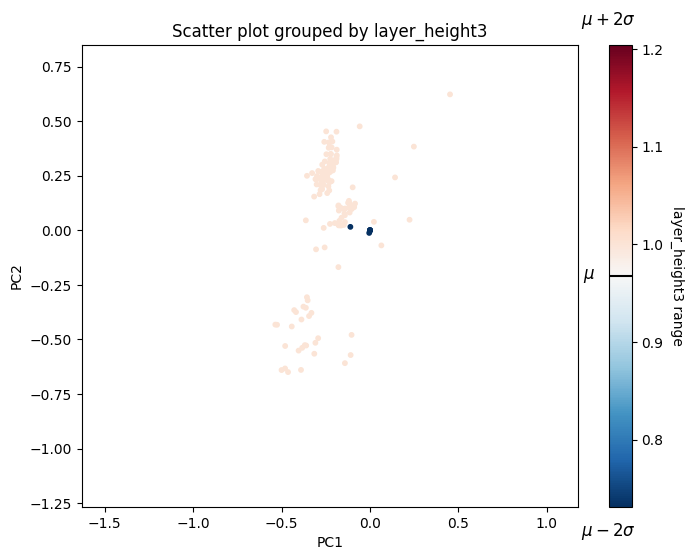

Identified outliers: 5


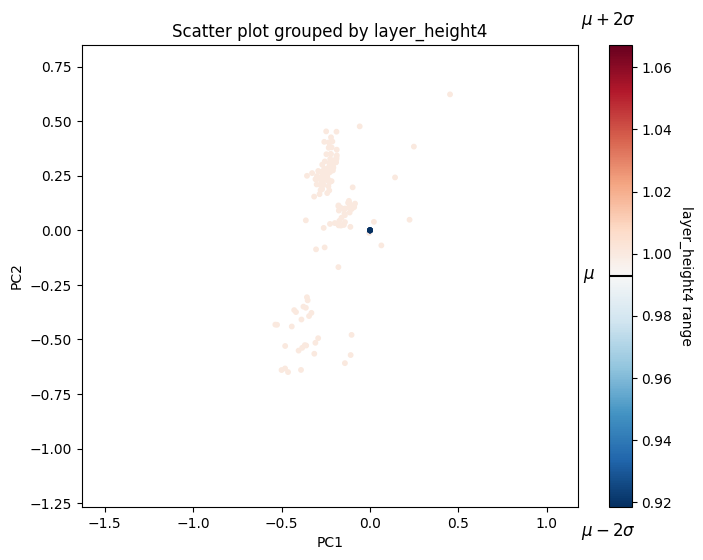

In [41]:
zz = out["zz"]

# z2 = np.vstack([zzz for zzz in zz if len(zzz) >0])
# plt.scatter(z2[:,0], z2[:,1])
# x1,y1 = polygon.exterior.coords.xy
# plt.plot(x1,y1)
s_K=2 # number of variances from mean

df_scatter = pd.DataFrame()
df_scatter["x"] = out['Ez.y'][:,0]
df_scatter["y"] = out['Ez.y'][:,1]
continuous_position = 0
for col_idx, colname in enumerate(train.columns):
    if var_distrib[col_idx] in ['categorical', 'bernoulli', "ordinal"]: 
    #     feature = "race"
        # le_name_mapping = dict(zip(le_dict[feature].classes_, le_dict[feature].transform(le.classes_)))

        # print(le_name_mapping)
        # labels_real = le_dict[feature].inverse_transform(train_original[feature])
        unique_labels = le_dict[colname].classes_
        le_name_mapping = dict(zip(le_dict[colname].classes_, le_dict[colname].transform(le_dict[colname].classes_)))
#         print(le_name_mapping)
        # Compare woman, 60+ y.o and people presenting both modalities
        zz = np.concatenate(out['zz'])
        df_scatter["c"] = train[colname]
        df_scatter["label"] = train_original[colname]
        # Convert the labels to numeric values
        labels, levels = pd.factorize(df_scatter['label'])

        # Create a scatter plot
        fig, ax = plt.subplots(figsize=(8, 6))
        scatter = ax.scatter(x=df_scatter['x'], y=df_scatter['y'], c=labels, cmap='Set1', s=10)

        # Add a title and axis labels
        ax.set_title('Scatter plot grouped by ' + colname)
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_xlim(x_lim[0], x_lim[1])
        ax.set_ylim(y_lim[0], y_lim[1])
        # Create a legend
        handles, labels = scatter.legend_elements()
        legend = ax.legend(handles, levels, loc='center left', bbox_to_anchor=(1.05, 0.5), title=colname, borderaxespad=0.)

        plt.show()
    else:
        # Create a scatter plot
        fig, ax = plt.subplots(figsize=(8, 6))
        minn = scaler.data_min_[continuous_position]
        maxx = scaler.data_max_[continuous_position]
        # calculate summary statistics
        data_mean, data_std = np.mean(train_original[colname]), np.std(train_original[colname])
        # identify outliers
        cut_off = data_std * s_K
        lower, upper = data_mean - cut_off, data_mean + cut_off
        # identify outliers
        outliers = [x for x in train_original[colname] if x < lower or x > upper]
        print('Identified outliers: %d' % len(outliers))
         
        
        scatter = ax.scatter(x=df_scatter['x'], y=df_scatter['y'], c=train_original[colname].astype(int), cmap='RdBu_r', s=10, vmin=lower, vmax=upper)

        # Add a title and axis labels
        ax.set_title('Scatter plot grouped by ' + colname)
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        cb = plt.colorbar(scatter)
        cb.ax.get_yaxis().labelpad = 15
        cb.ax.set_ylabel(colname + " range", rotation=270)

        # add a horizontal line to the colorbar axis
        cb.ax.hlines(data_mean, 0, 1, color="black")
        # Add an annotation at the mean value on the left of the colorbar
        cb.ax.annotate("$\mu$", xy=(cb.ax.get_xlim()[0], data_mean), xytext=(-10, 0),
                       textcoords="offset points", ha="right", va="center",
                       fontsize=12, color="black")
        cb.ax.annotate(r'$\mu + {} \sigma$'.format(s_K), xy=(0, upper), xytext=(0, 10),
                       textcoords="offset points", ha="center", va="bottom",
                       fontsize=12, color="black")
        cb.ax.annotate(r'$\mu - {} \sigma$'.format(s_K), xy=(0, lower), xytext=(0, -10),
                       textcoords="offset points", ha="center", va="top",
                       fontsize=12, color="black")
        # Create a legend
#         handles, labels = scatter.legend_elements()
#         legend = ax.legend(handles, levels, loc='center left', bbox_to_anchor=(1.05, 0.5), title=colname, borderaxespad=0.)
        continuous_position += 1
        ax.set_xlim(x_lim[0], x_lim[1])
        ax.set_ylim(y_lim[0], y_lim[1])
        plt.show()